# CNN for Image Classification

### Import Libraries

In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, ConcatDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torcheval.metrics.functional import (multiclass_accuracy, 
                                          multiclass_confusion_matrix, 
                                          multiclass_precision, 
                                          multiclass_recall)
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

### Load the data

In [60]:
# Batch size for training, validation and testing datasets
batch_size = 64

# Percentages for training, validation and training sets
train_split = 0.6
valid_split = 0.2
test_split = 0.2

In [61]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [62]:
train_data = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
test_data = datasets.CIFAR10('./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Concatenate the datasets
full_dataset = ConcatDataset([train_data, test_data])

len_full_dataset = len(full_dataset)
print("Full dataset length", len_full_dataset)

Full dataset length 60000


In [64]:
# Split data into training, validation and test datasets

# Seed the generator to achieve the same splits everytime
split_generator = torch.Generator().manual_seed(42) 

train_size = int(np.floor(train_split * len_full_dataset))
valid_size = int(np.floor(valid_split * len_full_dataset))
test_size = int(np.floor(test_split * len_full_dataset))

train_dataset, valid_dataset, test_dataset = random_split(full_dataset, 
                                                               [train_size, valid_size, test_size], 
                                                               split_generator)

In [65]:
print("Train dataset length: ", len(train_dataset))
print("Validation dataset length: ", len(valid_dataset))
print("Test dataset length: ", len(test_dataset))

Train dataset length:  36000
Validation dataset length:  12000
Test dataset length:  12000


In [66]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

In [67]:
# Image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a batch from dataset

In [68]:
def imshow(img):
    # Un-normalize the images
    img = img * 0.5 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0))) # Change the shape

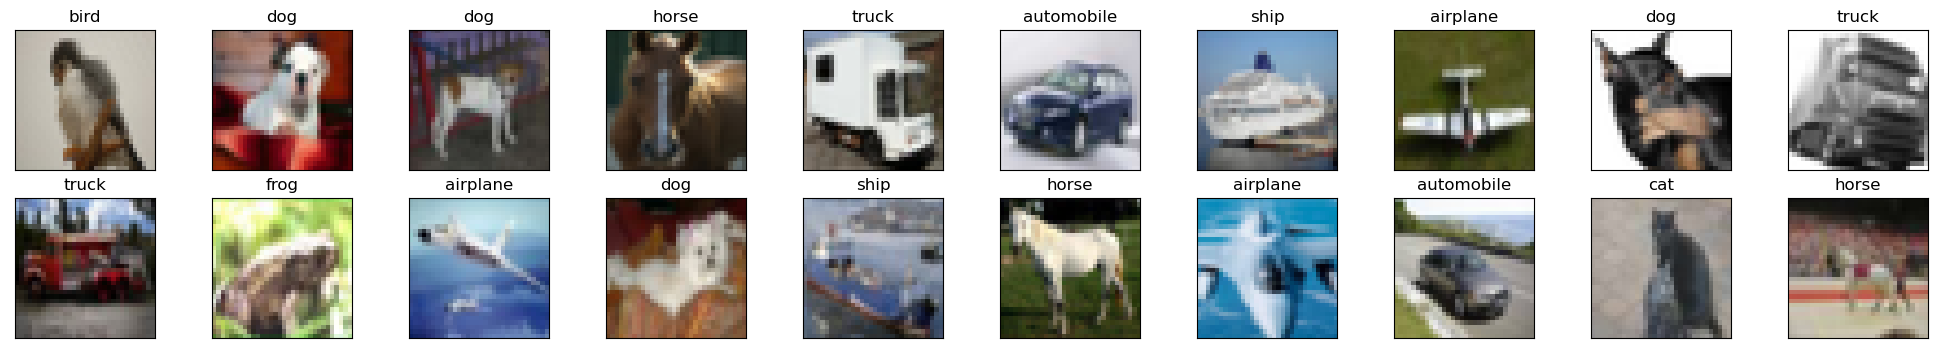

In [69]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [70]:
print("Batch Shape: ", images.shape)

Batch Shape:  (64, 3, 32, 32)


### Define the Network Architecture

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        
        # Second covolution block
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        
        # Third convolution block
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Linear layer (4 * 4 * 128 -> 128)
        self.fc1 = nn.Linear(4 * 4 * 128, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Dropout layer
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)
        
    def forward(self, x):
        
        # First block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        
        # Flattern
        x = x.view(-1, 4 * 4 * 128)
        
        # Linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)

        x = self.fc2(x)
        
        return x

In [83]:
# create the CNN
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
)

In [84]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU ...')
else:
    print('Training on GPU ...')

Training on GPU ...


In [85]:
if train_on_gpu:
    model.cuda()

### Loss Function & Optimizer

In [86]:
# Categorical cross entrophy loss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### Train the Network

In [87]:
n_epochs = 20

valid_loss_min = np.Inf

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    ############# Train the model #############
    model.train()
    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
    ############# Train the model #############
    with torch.no_grad():
        model.eval()
        for images, labels in valid_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
                
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += loss.item() * images.size(0)
            
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model when validation loss decreases
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,valid_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.814255 	Validation Loss: 1.437655
Validation loss decreased (inf --> 1.437655). Saving model ...
Epoch: 2 	Training Loss: 1.440143 	Validation Loss: 1.273536
Validation loss decreased (1.437655 --> 1.273536). Saving model ...
Epoch: 3 	Training Loss: 1.279124 	Validation Loss: 1.183062
Validation loss decreased (1.273536 --> 1.183062). Saving model ...
Epoch: 4 	Training Loss: 1.157949 	Validation Loss: 0.994856
Validation loss decreased (1.183062 --> 0.994856). Saving model ...
Epoch: 5 	Training Loss: 1.066669 	Validation Loss: 0.968797
Validation loss decreased (0.994856 --> 0.968797). Saving model ...
Epoch: 6 	Training Loss: 0.999872 	Validation Loss: 0.887118
Validation loss decreased (0.968797 --> 0.887118). Saving model ...
Epoch: 7 	Training Loss: 0.939763 	Validation Loss: 0.852382
Validation loss decreased (0.887118 --> 0.852382). Saving model ...
Epoch: 8 	Training Loss: 0.895114 	Validation Loss: 0.769691
Validation loss decreased (0.852382 --> 0

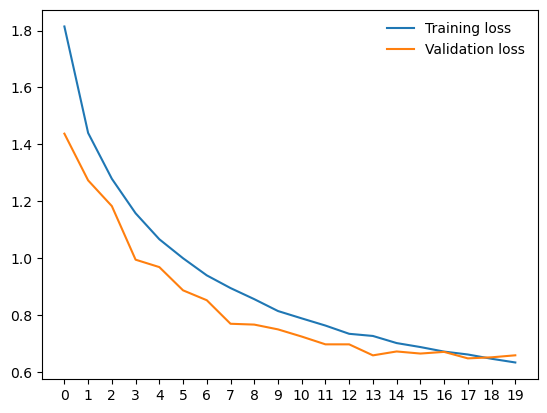

In [89]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xticks(range(20))
plt.show()

### Load the Model with Lowest Validation Loss

In [96]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

### Test the Trained Network

In [97]:
y_pred = torch.empty((0,10))
y_true = torch.empty((0,1))

test_loss = 0.0

with torch.no_grad():
    model.eval()
    
    for images, labels in test_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item() * images.size(0)

        y_pred = torch.vstack([y_pred, output.cpu()])
        y_true = torch.vstack([y_true, labels.view(-1,1).cpu()])
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.656758



In [98]:
_, pred = torch.max(y_pred, 1)

for i in range(10):
    class_accuracies = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64), average=None, num_classes=10)
    
    print('Test Accuracy of %10s: %.2f%%' % (classes[i], 100 * class_accuracies[i].item()))

overall_accuracy = multiclass_accuracy(pred, torch.squeeze(y_true).to(torch.int64))    
print('\nTest Accuracy (Overall): %.2f%% ' % (100. * overall_accuracy.item()))

Test Accuracy of   airplane: 74.07%
Test Accuracy of automobile: 91.00%
Test Accuracy of       bird: 71.79%
Test Accuracy of        cat: 58.24%
Test Accuracy of       deer: 78.18%
Test Accuracy of        dog: 63.06%
Test Accuracy of       frog: 86.32%
Test Accuracy of      horse: 75.74%
Test Accuracy of       ship: 89.49%
Test Accuracy of      truck: 87.29%

Test Accuracy (Overall): 77.50% 


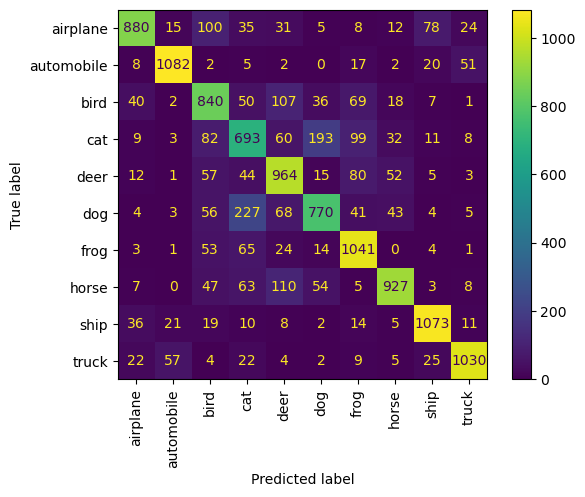

In [99]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(multiclass_confusion_matrix(pred, torch.squeeze(y_true).to(torch.int64), num_classes=10).numpy(), 
                              display_labels=classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [100]:
test_precision = multiclass_precision(pred, torch.squeeze(y_true).to(torch.int64), num_classes=10)
test_recall =  multiclass_recall(pred, torch.squeeze(y_true).to(torch.int64), num_classes=10)

print('\nTest Precision : %.5f' % (test_precision))
print('\nTest Recall : %.5f' % (test_recall))


Test Precision : 0.77500

Test Recall : 0.77500


### Helper Function to Train with Multiple Learning Rates

In [101]:
def train_model(learning_rate):
    # Create a new model
    model = Net()
    
    if train_on_gpu:
        model.cuda()
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training
    n_epochs = 20

    valid_loss_min = np.Inf

    train_losses, valid_losses = [], []

    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        ############# Train the model #############
        model.train()
        for images, labels in train_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        ############# Train the model #############
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()

                output = model(images)
                loss = criterion(output, labels)
                valid_loss += loss.item() * images.size(0)

        # Calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
            
    return train_losses, valid_losses

In [116]:
def plot_losses(train_losses, valid_losses, lr):
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.xticks(range(20))
    plt.title("Learning Rate: " + str(lr))
    plt.show()

In [103]:
train_losses_0001, valid_losses_00001 = train_model(0.0001)

Epoch: 1 	Training Loss: 2.038048 	Validation Loss: 1.718177
Epoch: 2 	Training Loss: 1.681327 	Validation Loss: 1.529472
Epoch: 3 	Training Loss: 1.558956 	Validation Loss: 1.443725
Epoch: 4 	Training Loss: 1.482282 	Validation Loss: 1.372959
Epoch: 5 	Training Loss: 1.427313 	Validation Loss: 1.318047
Epoch: 6 	Training Loss: 1.373413 	Validation Loss: 1.265240
Epoch: 7 	Training Loss: 1.329523 	Validation Loss: 1.231380
Epoch: 8 	Training Loss: 1.286326 	Validation Loss: 1.206601
Epoch: 9 	Training Loss: 1.255362 	Validation Loss: 1.150212
Epoch: 10 	Training Loss: 1.209364 	Validation Loss: 1.134693
Epoch: 11 	Training Loss: 1.191581 	Validation Loss: 1.113345
Epoch: 12 	Training Loss: 1.159901 	Validation Loss: 1.068581
Epoch: 13 	Training Loss: 1.133909 	Validation Loss: 1.059832
Epoch: 14 	Training Loss: 1.109556 	Validation Loss: 1.013874
Epoch: 15 	Training Loss: 1.083732 	Validation Loss: 1.008145
Epoch: 16 	Training Loss: 1.060146 	Validation Loss: 0.973364
Epoch: 17 	Traini

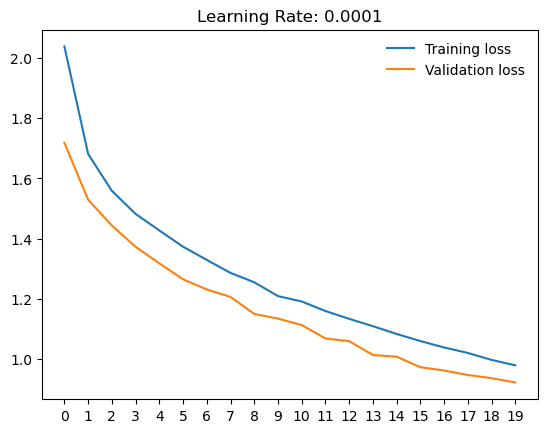

In [117]:
plot_losses(train_losses_0001, valid_losses_00001, 0.0001)

In [105]:
train_losses_01, valid_losses_01 = train_model(0.01)

Epoch: 1 	Training Loss: 2.305445 	Validation Loss: 2.304071
Epoch: 2 	Training Loss: 2.303646 	Validation Loss: 2.303637
Epoch: 3 	Training Loss: 2.303619 	Validation Loss: 2.304077
Epoch: 4 	Training Loss: 2.303527 	Validation Loss: 2.303404
Epoch: 5 	Training Loss: 2.303698 	Validation Loss: 2.303093
Epoch: 6 	Training Loss: 2.303596 	Validation Loss: 2.303446
Epoch: 7 	Training Loss: 2.303582 	Validation Loss: 2.303683
Epoch: 8 	Training Loss: 2.303414 	Validation Loss: 2.303129
Epoch: 9 	Training Loss: 2.303526 	Validation Loss: 2.302923
Epoch: 10 	Training Loss: 2.303595 	Validation Loss: 2.303376
Epoch: 11 	Training Loss: 2.303567 	Validation Loss: 2.304131
Epoch: 12 	Training Loss: 2.303682 	Validation Loss: 2.303610
Epoch: 13 	Training Loss: 2.303438 	Validation Loss: 2.303505
Epoch: 14 	Training Loss: 2.303651 	Validation Loss: 2.304282
Epoch: 15 	Training Loss: 2.303534 	Validation Loss: 2.303077
Epoch: 16 	Training Loss: 2.303500 	Validation Loss: 2.303111
Epoch: 17 	Traini

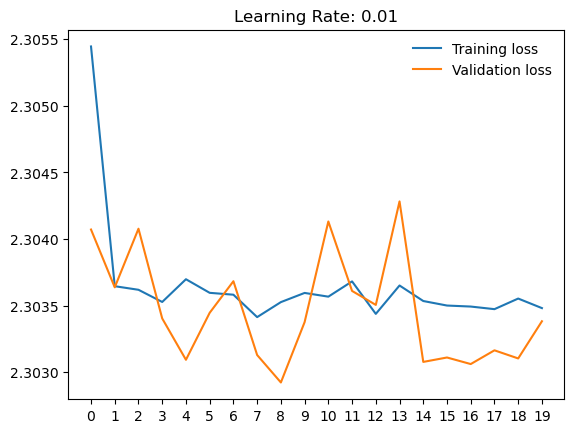

In [118]:
plot_losses(train_losses_01, valid_losses_01, 0.01)

In [107]:
train_losses_1, valid_losses_1 = train_model(0.1)

Epoch: 1 	Training Loss: 30360.658593 	Validation Loss: 2.309321
Epoch: 2 	Training Loss: 2.310852 	Validation Loss: 2.312955
Epoch: 3 	Training Loss: 2.311659 	Validation Loss: 2.312428
Epoch: 4 	Training Loss: 2.311975 	Validation Loss: 2.317475
Epoch: 5 	Training Loss: 2.311092 	Validation Loss: 2.312446
Epoch: 6 	Training Loss: 2.311910 	Validation Loss: 2.316519
Epoch: 7 	Training Loss: 2.310933 	Validation Loss: 2.314222
Epoch: 8 	Training Loss: 2.311227 	Validation Loss: 2.313262
Epoch: 9 	Training Loss: 2.311569 	Validation Loss: 2.310696
Epoch: 10 	Training Loss: 2.312692 	Validation Loss: 2.305933
Epoch: 11 	Training Loss: 2.312066 	Validation Loss: 2.309280
Epoch: 12 	Training Loss: 2.311793 	Validation Loss: 2.308893
Epoch: 13 	Training Loss: 2.312571 	Validation Loss: 2.313996
Epoch: 14 	Training Loss: 2.310973 	Validation Loss: 2.311806
Epoch: 15 	Training Loss: 2.311400 	Validation Loss: 2.310231
Epoch: 16 	Training Loss: 2.311887 	Validation Loss: 2.319233
Epoch: 17 	Tr

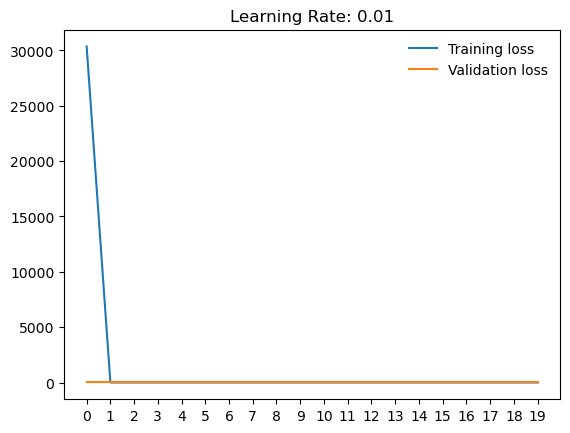

In [121]:
plot_losses(train_losses_1, valid_losses_1, 0.01)

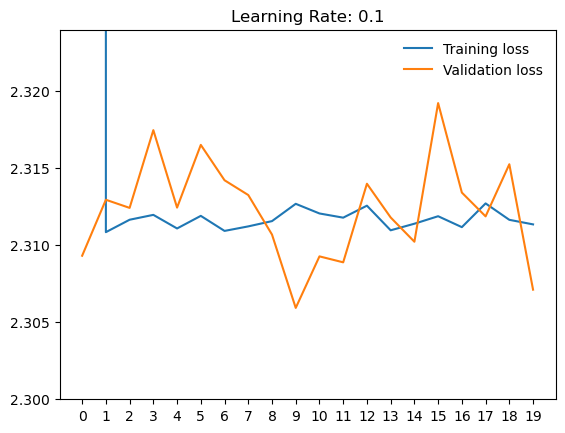

In [119]:
# Enlarge the graph
plt.plot(train_losses_1, label='Training loss')
plt.plot(valid_losses_1, label='Validation loss')
plt.legend(frameon=False)
plt.xticks(range(20))
plt.ylim((2.3,2.324))
plt.title("Learning Rate: " + str(0.1))
plt.show()